<a href="https://colab.research.google.com/github/neon-iot/cognitive_radios/blob/main/notebooks/LoRa_CNN_The_Gaussians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>IDENTIFICACIÓN DE HUELLAS DACTILARES POR RADIO FRECUENCIA (RFFI) DE DISPOSITIVOS LORA USANDO CNN<h1></center>

##GRUPO: *The Gaussians*
###INTEGRANTES:
* Marco Valentino Di Giannantonio.
* Juan Ignacio Ulla.
* Leandro Augusto Villa.

<center><h1><b>MARCO TEÓRICO<h1></center>

# **Modulación LoRa**

La modulación LoRa es una especificación para redes de área amplia y baja potencia (LPWAN: Low Power Wide Area Network), muy utilizadas en el campo de Internet de las cosas (IOT).<br>

LoRa (Long Range) es una técnica de modulación inalámbrica derivada de la tecnología Chirp Spread Spectrum (CSS). Codifica información en ondas de radio utilizando pulsos de "chirrido", similar a la forma en que se comunican los delfines y los murciélagos. <br>

***Chirp*** (Compressed High Intensity Radar Pulse): significa "Pulso de radar de alta intensidad comprimido". Es una señal senoidal cuya frecuencia aumenta o disminuye linealmente con el tiempo. Es muy común es el sonar y el radar. También se utiliza en espectro ensanchado.

<h3> Caraterísticas de la modulación</h3>
<li>Es resistente a las perturbaciones y se puede recibir a través de grandes distancias. <br>
<li>Es ideal para aplicaciones que transmiten pequeños fragmentos de datos con tasas de bits bajas. Los datos se pueden transmitir a una distancia mayor en comparación con tecnologías como WiFi, Bluetooth o ZigBee. Estas características hacen que LoRa sea ideal para sensores y actuadores que funcionan en modo de bajo consumo. <br>

<li>LoRa puede funcionar en las bandas de subgigahercios sin licencia, por ejemplo, 915 MHz (América), 868 MHz (Europa) y 433 MHz(Asia).<br>

Cabe destacar la importancia de no confundir LoRa con LoRaWAN. LoRa es un método para transmitir señales de radio que utiliza un formato multisimbólico de ***chirp*** para codificar información. Es un sistema propietario hecho por el fabricante de chips Semtech, aunque otros fabricantes pueden licenciar la IP LoRa. Por otro lado, LoRaWAN es un protocolo de red de área amplia de baja potencia construido sobre la técnica de modulación de radio LoRa.

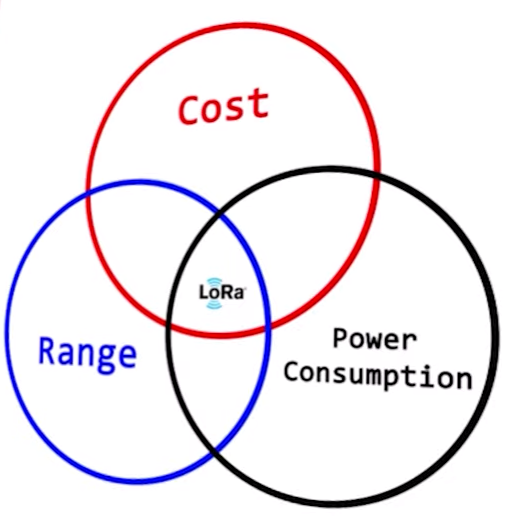

Podemos ver gráficamente las señales de chirrido (up y down chirp) que utiliza un paquete LoRa para transmitir los símbolos en función de amplitud y frecuencia

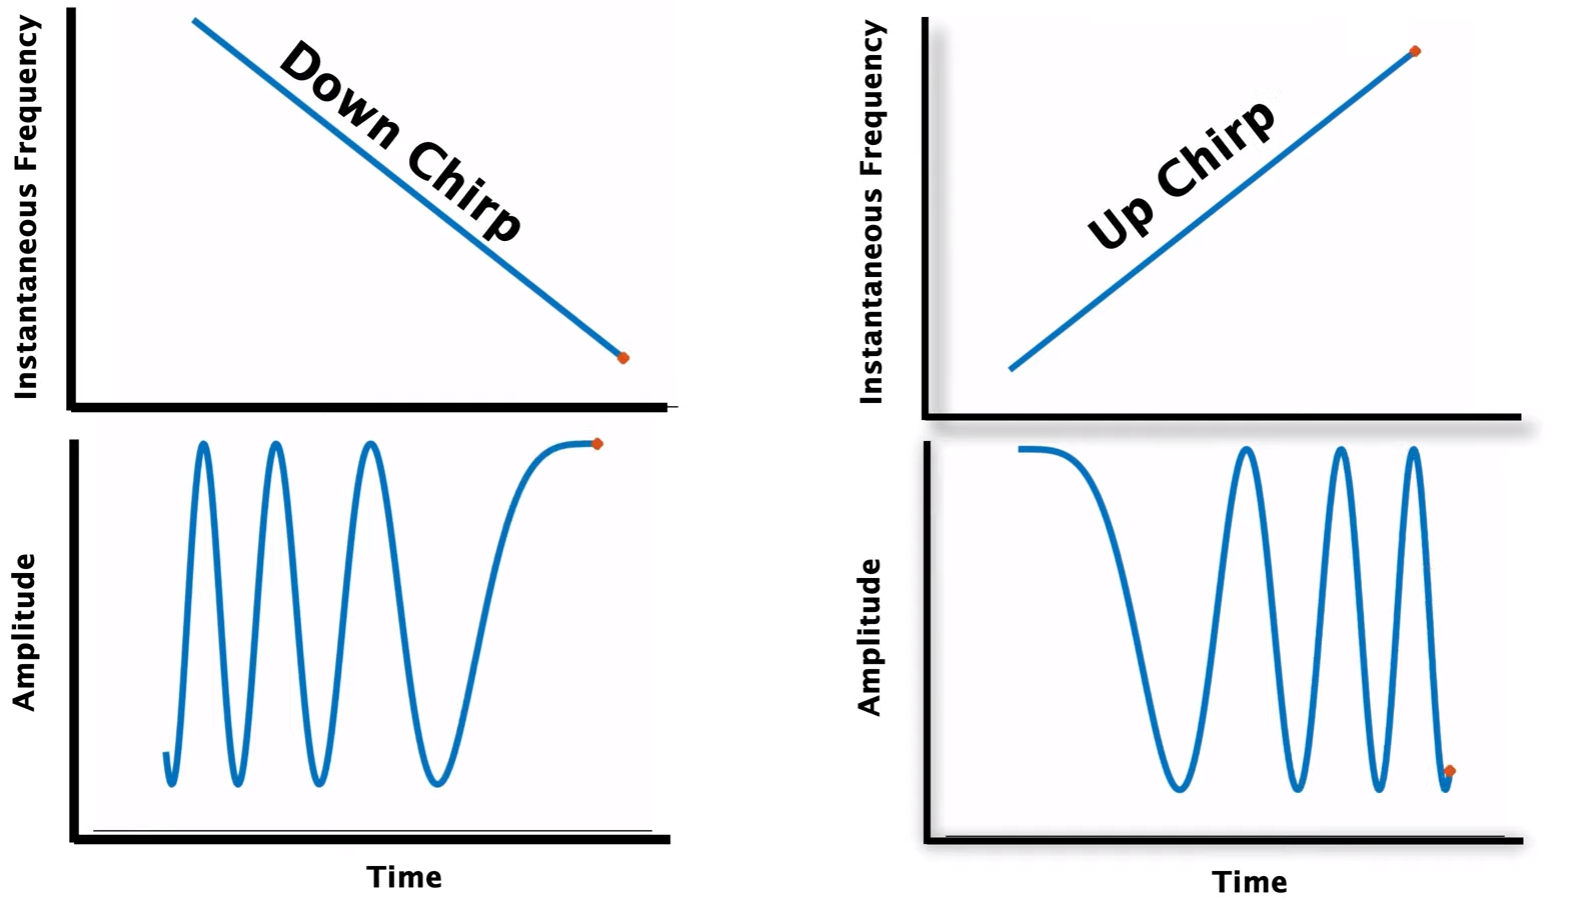

##Preámbulo de LoRa:
Un preámbulo LoRa es una secuencia de símbolos que se transmite antes del mensaje real en un sistema de comunicación LoRa (Long Range). El preámbulo tiene varias funciones importantes, principalmente la indicación del comienzo de una nueva transmisión.

En la comunicación LoRa, el preámbulo está compuesto por una serie de símbolos idénticos que se transmiten a una tasa y con una modulación fija. 

Cuando el receptor detecta el preámbulo, comienza a muestrear la señal para determinar el tiempo de inicio.

Un paquete LoRa con el estándar europeo (que es el utilizado en nuestro proyecto) consta de 8 señales up chirp (preámbulo), 2 down chirp (sincronización del receptor) y los datos a enviar (Payload).

###A modo de ejemplo presentamos la siguiente transmision LoRa: <br>


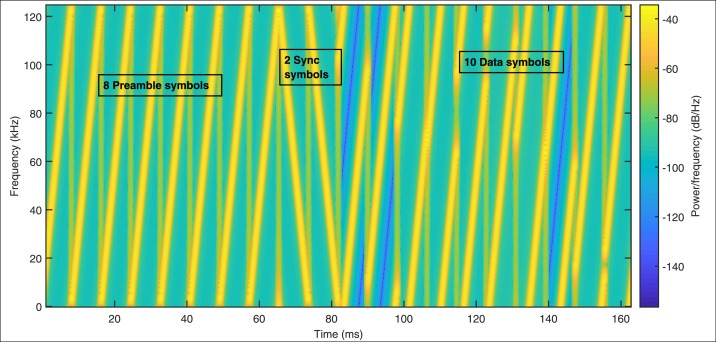

<center><h1><b>NUESTRO PROYECTO<h1></center>

El proyecto consiste en identificar qué transmisor (dispositivo LoRa) ha transmitido cierto paquete. Esto lo realizamos mediante la identificación de huellas dactilares por radiofrecuencia (**RFFI**) a través del uso de un algoritmo de redes neuronales convolucionales (CNN).<br>
 
RFFI es una técnica de autenticación de dispositivos basada en las deficiencias del hardware del mismo generado durante su manufcatura. Estas deficiencias son tan pequeñas que la funcionalidad del mismo no se ve afectada, pero al ser únicas podemos tratarlas como una huella digital propia del dispositivo. <br>

La finalidad del uso de CNN es entrenar el algoritmo para que pueda identificar estas huellas y ser capaz de reconocerlas al recibir una transmisión de cualquier dispositivo. <br>

Para llevar a cabo el proyecto se usó una base de datos de señales que corresponden a 30 dispositivos LoRa Pycom LoPy4 (recibidos mediante un receptor USRP N210 SDR). Cada señal contiene solamente el preámbulo de la señal transmitida con el fin de que la red neuronal no aprenda sobre protocolos del dispositivo.



##OBTENCION DE DATOS

Basándonos en los papers adjuntos en la bibliografía, utilizamos los datasets de uno de ellos para entrenar y testear nuestra red. Los datos de los dispositivos fueron recolectados en 2 situaciones diferentes:<br>
<ol><li>TRAIN: para entrenar, los datos se tomaron en una habitación residencial con línea de visión (LOS) y distanciados 1,5 metros. <br>
El primer data set se compone de 500 paquetes por dispositivo en situación de LOS.<br> 
El segundo y tercer dataset contienen 1000 paquetes (generados con aumentación) por dispositivo. El segundo con el efecto multipath y el tercero con multipath y Doppler. En los tres casos, ya tienen la compensación de CFO. <br>
<li>TEST: Los datos se recolectaron en una sala de reuniones. Para ello, se transmitieron 400 paquetes por dispositivo en los diferentes escenarios mencionados (estacionario, con multipath, Doppler y LOS). <br></ol> 

**Una aclaración importante es que los dispositivos transimitieron de forma secuencial, es decir, no se hace un envio simultaneo por lo que no se produce interferencia entre las señales recibidas.**

A continuación, mostramos un plano de la sala donde se recolectaron los datos para el TEST (no está incluída en el paper una imagen del lugar utilizado para la toma de datos para TRAIN):

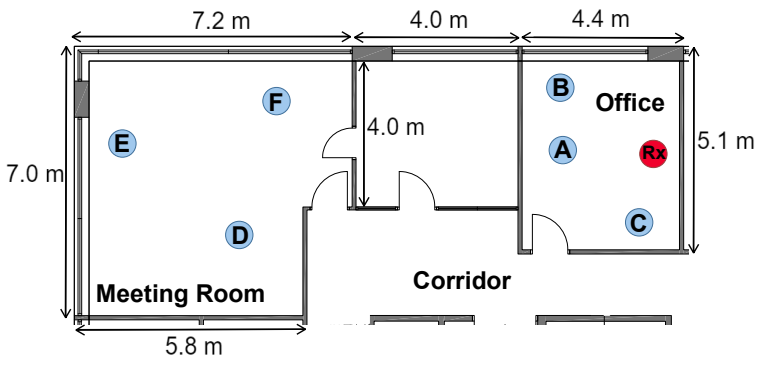

<center><h1><b>DESARROLLO<h1></center>

##Importamos las librerias necesarias:

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from numpy import sum,sqrt
from numpy.random import standard_normal, uniform
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc , confusion_matrix
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

##Mostramos una representación de una señal LoRa en el dominio del tiempo y en el dominio de tiempo-frecuencia. La señal corresponde a la emisión de un símbolo "s" elegible.

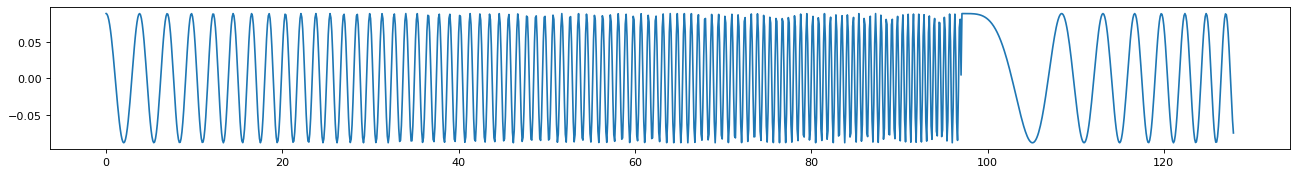

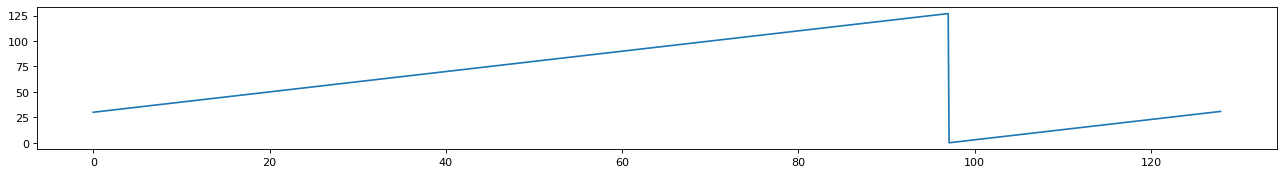

In [ ]:
SF = 7
muestrasTiempo = []
muestrasFrecuencia = []
s = 30
k = 0    
delta = 0.1
largo = int((2**SF)/delta)
fMax = (2**SF)-1


for n in range(largo):  
  muestrasTiempo.append((1/(np.sqrt(2**SF))) * np.exp((1j*2*np.pi) * ((s+k)) * (k/(2**SF)))) 
  muestrasFrecuencia.append(s+k)
  k = k + delta
  if((s+k) > fMax): 
    s = 0
    k = 0

# Señal en el dominio del tiempo
t= np.arange(0, 128, 0.1)
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(3,1,1)
plt.plot(t,np.real(muestrasTiempo))

# Señal en el dominio del tiempo-frecuencia
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(3,1,1)
plt.plot(t,np.real(muestrasFrecuencia))





##Cargamos las tres bases de datos para el entrenamiento de la CNN:
* FileTrainNoAug: paquetes en LOS, sin multipath ni doppler.
* FileTrainAug0Hz: paquetes con multipath sin doppler.
* FileTrainAugDoppler: paquetes con multipath y doppler.

##Además, mostramos la representación de un paquete en el dominio del tiempo (recordar que nos estamos manejando solo con el preambulo de LoRa).

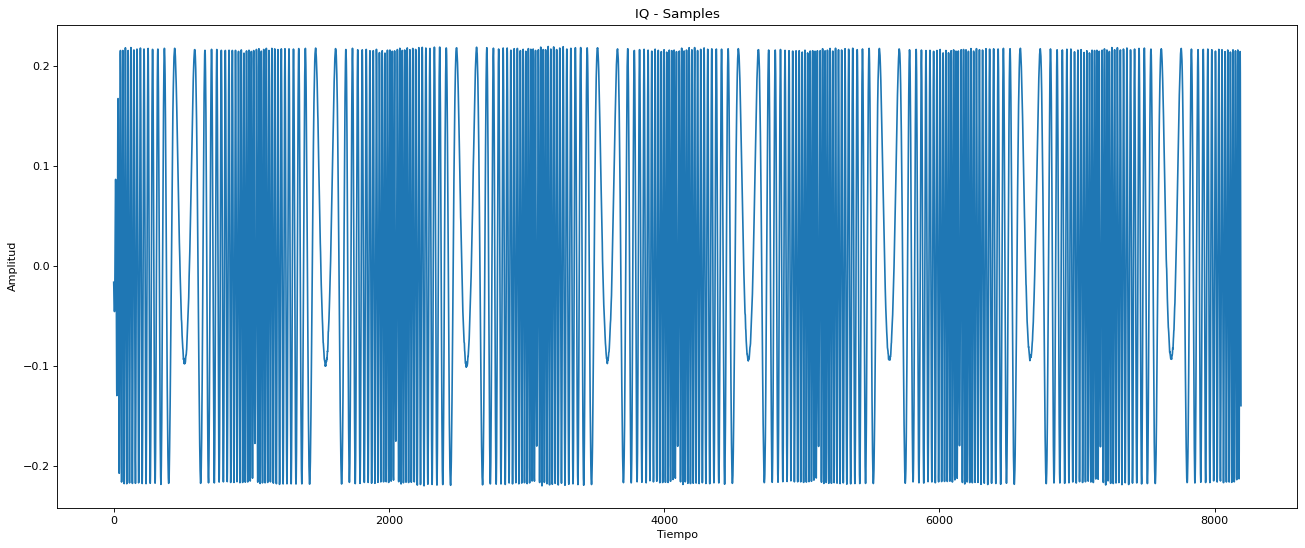

In [ ]:
fileTrainNoAug = '/content/drive/MyDrive/Comunicaciones Digitales PRO/dataset/Train/dataset_training_no_aug.h5'
f = h5py.File(fileTrainNoAug, "r")

dataTrainNoAug = f.get("data")
labelTrainNoAug = f.get("label")

t= np.arange(0, 8192, 1)

plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.title("IQ - Samples")
plt.ylabel("Amplitud")
plt.xlabel("Tiempo")
plt.plot(t,np.array(dataTrainNoAug[0, :8192])) 


fileTrainAug0Hz = '/content/drive/MyDrive/Comunicaciones Digitales PRO/dataset/Train/dataset_training_aug_0hz.h5'
f = h5py.File(fileTrainAug0Hz, "r")
dataTrainAug0Hz = f.get("data")
labelTrainAug0Hz = f.get("label")


fileTrainAugDoppler = '/content/drive/MyDrive/Comunicaciones Digitales PRO/dataset/Train/dataset_training_aug.h5'
f = h5py.File(fileTrainAugDoppler, "r")
dataTrainAugDoppler = f.get("data")
labelTrainAugDoppler = f.get("label")




##Funciones útiles:

In [ ]:
# Expresamos cada muestra de la señal como una muestra compleja.

def convertirAComplejo(data):
  num_filas = data.shape[0]
  num_col = data.shape[1] 
  datos_complejos = np.zeros([num_filas,round(num_col/2)],dtype=complex)
  datos_complejos = data[:,:round(num_col/2)] + 1j*data[:,round(num_col/2):]

  return datos_complejos

In [ ]:
# Ordena la base de datos y llama a la funcion "convertirAComplejo".

def cargar_iq_samples(file_path, disp_rango, paq_rango):
  
  f = h5py.File(file_path,'r')
  label = f['label'][:]
  label = label.astype(int)
  label = np.transpose(label)
  label = label - 1

  label_comienzo = int(label[0]) + 1
  label_final = int(label[-1]) + 1
  num_disp = label_final - label_comienzo + 1
  num_paq = len(label)
  num_paq_por_disp = int(num_paq/num_disp)
  
  print('Dispositivo ' + str(label_comienzo) + ' al dispositivo ' + 
        str(label_final) + ', ' + str(num_paq_por_disp) + ' paquetes por dispositivo.')
  
  listaDeIndicesDisp = []
  
  for disp_idx in disp_rango:
    
      indices_disp = np.where(label==disp_idx)[0][paq_rango].tolist()
      listaDeIndicesDisp.extend(indices_disp)


  data = f['data'][listaDeIndicesDisp]
  data = convertirAComplejo(data)

  
  label = label[listaDeIndicesDisp]
    
  f.close()
  return data,label

In [ ]:
# Normalizamos la señal con el objetivo de que la CNN no aprenda sobre la potencia de la señal. Se hace debido a que no se espera
# que los sistemas RFFI diferencien los dispositivos por diferencias de potencia. El motivo de esto es que la potencia de la señal es susceptible a la
# distancia debido a que a medida que sea mayor la distancia a la que esté el dispositivo del receptor, la potencia de la señal será más baja.

def normalizacion(data):
  
  s_norm = np.zeros(data.shape, dtype=complex)
  
  for i in range(data.shape[0]):
      amplitud_señal = np.abs(data[i])
      rms = np.sqrt(np.mean(amplitud_señal**2))
      s_norm[i] = data[i]/rms
  
  return s_norm  

In [ ]:
# Debido a la naturaleza de la señal LoRa la información útil de la misma se encuentra en el centro del espectrograma.
# Por este motivo cortamos los extremos del espectrograma con esta función.

def recortar_espectrograma(x):
  
  num_filas = x.shape[0]
  espectrograma_cortado = x[round(num_filas*0.3):round(num_filas*0.7)]

  return espectrograma_cortado

El espectrograma se ve afectado tanto por el canal inalámbrico como por el hardware específico del dispositivo.

Para generar el espectrograma de cada señal lo que vamos a realizar es la transformada de tiempo corto de Fourier (STFT) de cada una usando ventanas de tiempo. La STFT se realiza para analizar la variación del espectro en frecuencia de la señal en el tiempo.

Sin embargo, este no es un espectrograma indpendiente del canal. Para lograr esta independencia, lo que hacemos es tomar ventanas de tiempo muy pequeñas de forma que la influencia del canal en ventanas adyacentes se pueda considerar
igual. Gracias a esto, hacemos el cociente entre la FFT de la ventana siguiente y la FFT de la ventana anterior, eliminando la influencia del canal.

In [ ]:
def generar_espectrograma_individual_independiente_del_canal(sig, largo_ventana=256, overlap=128):
  '''Convierte la señal IQ samples a un espectrograma independiente del canal'''
  # Transformada de tiempo corto de Fourier (STFT).
  f, t, espectrograma = stft(sig, 
                          window='boxcar', 
                          nperseg= largo_ventana, 
                          noverlap= overlap, 
                          nfft= largo_ventana,
                          return_onesided=False, 
                          padded = False, 
                          boundary = None)

  # Ajustamos la frecuencia central.
  espectrograma = np.fft.fftshift(espectrograma, axes=0)

  # Generamos el espectrograma independiente del canal.
  espectrograma_independiente_del_canal = espectrograma[:,1:]/espectrograma[:,:-1]    

  # Expresamos la magnitud del espectrograma en [dB].      
  amplitud_espectrograma_independiente_del_canal = np.log10(np.abs(espectrograma_independiente_del_canal)**2)  
  
  return amplitud_espectrograma_independiente_del_canal

In [ ]:
# Generamos los espectrogramas de todas las señales con uso de la función anterior.

def crear_espectrograma_independiente_del_canal(data):
  # Normalizamos las IQ samples 
  data = normalizacion(data)
  
  # Calculamos el tamaño de los espectrogramas independientes del canal.
  num_paquetes = data.shape[0]
  num_filas = int(256*0.4)
  num_columnas = int(np.floor((data.shape[1]-256)/128 + 1) - 1)
  espectrograma_independiente_del_canal = np.zeros([num_paquetes, num_filas, num_columnas, 1])
  
  # Convertimos las IQ samples a un espectrograma independiente del canal.
  for i in range(num_paquetes):
              
      amplitud_espectrograma_independiente_del_canal = generar_espectrograma_individual_independiente_del_canal(data[i])
      amplitud_espectrograma_independiente_del_canal = recortar_espectrograma(amplitud_espectrograma_independiente_del_canal)
      espectrograma_independiente_del_canal[i,:,:,0] = amplitud_espectrograma_independiente_del_canal
      
  return espectrograma_independiente_del_canal

Dispositivo 1 al dispositivo 30, 500 paquetes por dispositivo.
(15000, 8192)
Dispositivo 1 al dispositivo 30, 1000 paquetes por dispositivo.
(30000, 8192)
Dispositivo 1 al dispositivo 30, 1000 paquetes por dispositivo.
(30000, 8192)


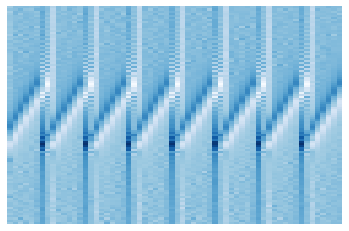

In [ ]:
# Obtenemos los espectrogramas relacionados con las bases de datos de entrenamiento.

data_trainNoAug, label_trainNoAug = cargar_iq_samples(fileTrainNoAug, np.arange(0,30, dtype = int), np.arange(0,500, dtype = int))
print(data_trainNoAug.shape)


data_trainAugDoppler, label_trainAugDoppler = cargar_iq_samples(fileTrainAugDoppler, np.arange(0,30, dtype = int), np.arange(0,1000, dtype = int))
print(data_trainAugDoppler.shape)

data_trainAug0Hz, label_trainAug0Hz = cargar_iq_samples(fileTrainAug0Hz, np.arange(0,30, dtype = int), np.arange(0,1000, dtype = int))
print(data_trainAug0Hz.shape)

# Espectrogramas de un solo dataset sin augmentation
data_trainMALO = crear_espectrograma_independiente_del_canal(data_trainNoAug)
# Espectrogramas de los tres datasets de entrenamiento (No Augmentation, Mulipath y Multipath + Doppler)
data_trainPRO = crear_espectrograma_independiente_del_canal(np.vstack((data_trainNoAug, data_trainAugDoppler, data_trainAug0Hz)))



# Gráfico espectrograma
plt.figure()
sns.heatmap(data_trainPRO[0,:,:,0],xticklabels=[], yticklabels=[], cmap='Blues', cbar=False)
plt.gca().invert_yaxis()




#CNN

Las redes neuronales convolucionales (CNN) son un tipo de red neuronal que se utilizan principalmente en tareas de reconocimiento y procesamiento de imágenes. Están inspirados en la forma en que el cerebro humano procesa la información visual y están diseñados para reconocer patrones y características dentro de las imágenes.

Una CNN se compone de varias capas, incluidas capas convolucionales, capas de agrupación y capas 'full connected'. Las capas convolucionales realizan la extracción de características mediante la aplicación de filtros a la imagen de entrada para detectar patrones y bordes. A su vez, las capas de agrupación reducen la dimensionalidad de los mapas de características, lo que hace que el modelo sea más eficiente. Finalmente, las capas 'full-connected' usan las características extraídas por las capas anteriores para clasificar la imagen.

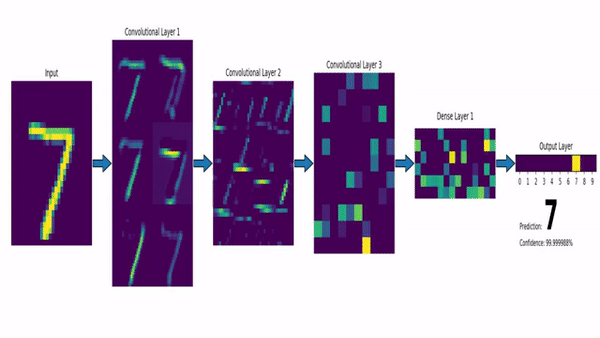

##Definimos los datos de entrenamiento del modelo:
####Este modelo es el que se entrenará con paquetes (ejemplos) que no contengan efecto Doppler ni Multipath.

In [ ]:
x_train = data_trainMALO
y_train = labelTrainNoAug[0]

y_train = to_categorical(y_train, 31)
print(y_train)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


## Cargamos la base de datos de Testeo (los paquetes de la base de datos contienen LOS (Line Of Sight), Doppler y Multipath) y luego generamos los espectrogramas independientes del canal para cada uno de los paquetes de la base de datos.

Dispositivo 1 al dispositivo 30, 400 paquetes por dispositivo.


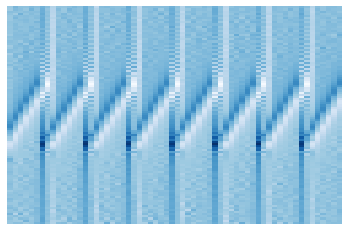

In [ ]:
filenameTest = '/content/drive/MyDrive/Comunicaciones Digitales PRO/dataset/Test/dataset_seen_devices.h5'
f = h5py.File(filenameTest, "r")
dataTest = f.get("data")
labelTest = f.get("label")


data_test, label_test = cargar_iq_samples(filenameTest, np.arange(0,30, dtype = int), np.arange(0,400, dtype = int))
data_test = crear_espectrograma_independiente_del_canal(data_test)


#Grafico del espectrograma
plt.figure()
sns.heatmap(data_test[0,:,:,0],xticklabels=[], yticklabels=[], cmap='Blues', cbar=False)
plt.gca().invert_yaxis()


##Definimos los datos de testeo del modelo:

In [ ]:
x_test = data_test
y_test = np.array(labelTest[0])
y_test = to_categorical(y_test, 31)


##Definimos la estructura de la red convolucional (CNN) y hacemos el entrenamiento de la misma.

In [ ]:
#ESTRUCTURA DE LA CNN SI USAMOS ESPECTROGRAMA MALO

#extracción de características 
modeloIQ = keras.Sequential() #inicializo
#conv 1
modeloIQ.add( keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding="same",strides= 1 ,activation="relu",input_shape=(102,62,1)))  #descubre caracteristicas
modeloIQ.add( keras.layers.MaxPool2D( (2,2),strides= 2 ) ) # agrupacion o reduc.

#conv 2
modeloIQ.add( keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same",strides= 1 ,activation="relu"))  #descubre caracteristicas
modeloIQ.add( keras.layers.MaxPool2D( (2,2),strides= 2 ) ) # agrupacion o reduc.

#conv 3
modeloIQ.add( keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same",strides= 1 ,activation="relu"))  #descubre caracteristicas


#caracterizacion
modeloIQ.add( keras.layers.Flatten()) #prepara (aplana) para las input del MLP
modeloIQ.add(keras.layers.Dense(120, activation=keras.activations.relu)) #capa oculta 
modeloIQ.add(keras.layers.Dense(31, activation=keras.activations.softmax))  #capa de salida 
modeloIQ.summary()

print(x_train.shape)
print(y_train.shape)


modeloIQ.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


r = modeloIQ.fit(x_train, y_train, batch_size=32, epochs=30)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 102, 62, 8)        80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 51, 31, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 51, 31, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 15, 32)        4640      
                                                                 
 flatten (Flatten)           (None, 12000)             0

##Realizamos la predicción del dispositivo que ha enviado el paquete utilizando la red ya entrenada. Una vez hechas las predicciones utilizamos métricas para evaluar el desempeño de la CNN, las métricas que utilizamos son el Accuracy y la Matriz de Confusión.

375/375 [==============================] - 1s 2ms/step
Accuracy:
0.6363333333333333


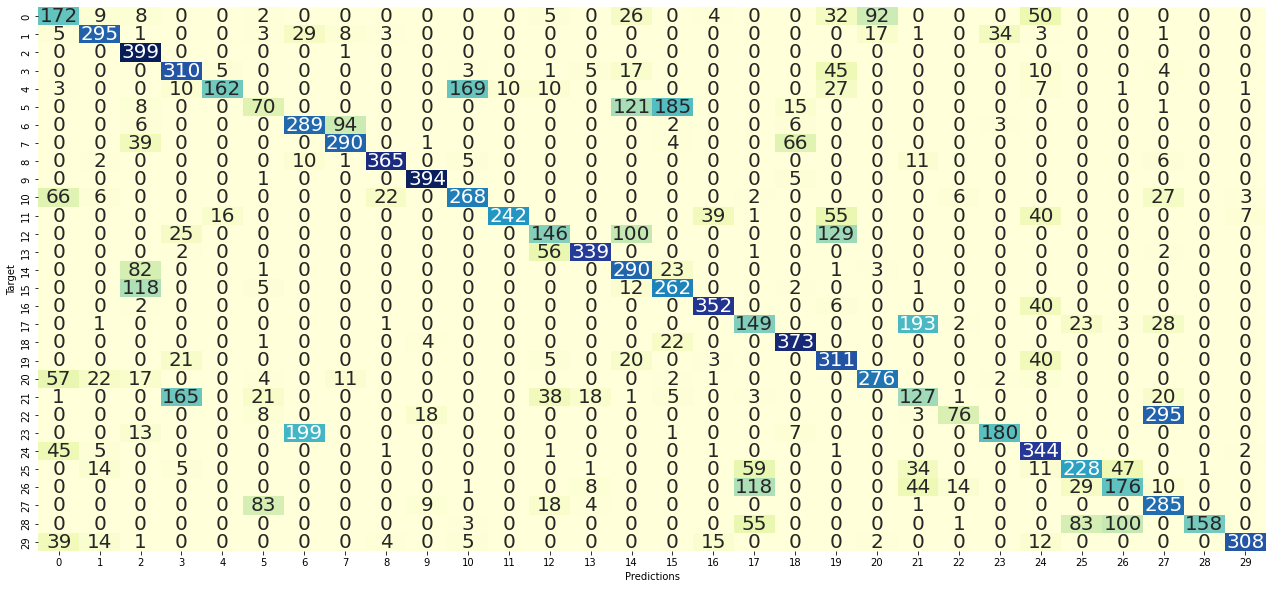

In [ ]:
predictions = modeloIQ.predict(x_test)

predicciones = []
for i in range(12000):
 predicciones.append(np.argmax(predictions[i]))

y_testeo = []
for i in range(12000):
 y_testeo.append(np.argmax(y_test[i]))

cm=confusion_matrix(y_testeo, predicciones)
cm_df=pd.DataFrame(cm)
plt.figure(figsize=(22,10))
sns.heatmap(cm_df, annot=True, cmap= "YlGnBu", annot_kws={"size": 20}, cbar=False, fmt='g');
plt.xlabel('Predictions');
plt.ylabel('Target');

print("Accuracy:")
aciertos = 0
for i in range(12000):
  if(y_testeo[i]==predicciones[i]):
    aciertos = aciertos+1

accuracy = aciertos/12000
print(accuracy)


##Definimos los datos de entrenamiento del modelo, este modelo es el que se va a entrenar con paquetes (ejemplos) que contengan efecto Doppler, Multipath y LOS (Line Of Sight).

##Luego definimos la estructura de la red convolucional (CNN) y hacemos el entrenamiento de la misma.

In [ ]:
x_train = data_trainPRO
y_train = np.concatenate((labelTrainNoAug[0],labelTrainAug0Hz[0],labelTrainAugDoppler[0]))
y_train = to_categorical(y_train, 31)

#ESTRUCTURA DE LA CNN SI USAMOS ESPECTROGRAMA BUENO

#extracción de características 
modeloIQ = keras.Sequential() #inicializo
#conv 1
modeloIQ.add( keras.layers.Conv2D(filters=8, kernel_size=(3,3), padding="same",strides= 1 ,activation="relu",input_shape=(102,62,1)))  #descubre caracteristicas
modeloIQ.add( keras.layers.MaxPool2D( (2,2),strides= 2 ) ) # agrupacion o reduc.

#conv 2
modeloIQ.add( keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same",strides= 1 ,activation="relu"))  #descubre caracteristicas
modeloIQ.add( keras.layers.MaxPool2D( (2,2),strides= 2 ) ) # agrupacion o reduc.

#conv 3
modeloIQ.add( keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same",strides= 1 ,activation="relu"))  #descubre caracteristicas


#caracterizacion
modeloIQ.add( keras.layers.Flatten()) #prepara (aplana) para las input del MLP
modeloIQ.add(keras.layers.Dense(120, activation=keras.activations.relu)) #capa oculta 
modeloIQ.add(keras.layers.Dense(31, activation=keras.activations.softmax))  #capa de salida 
modeloIQ.summary()


modeloIQ.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


r = modeloIQ.fit(x_train, y_train, batch_size=32, epochs=30)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 102, 62, 8)        80        
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 51, 31, 8)        0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 51, 31, 16)        1168      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 25, 15, 32)        4640      
                                                                 
 flatten_3 (Flatten)         (None, 12000)            

##Realizamos la predicción del dispositivo que ha enviado el paquete utilizando la red ya entrenada. Una vez hechas las predicciones, al igual que en caso anterior utilizamos el Accuracy y la Matriz de Confusión para evaluar el desempeño de la CNN.

375/375 [==============================] - 1s 2ms/step
Accuracy:
0.90875


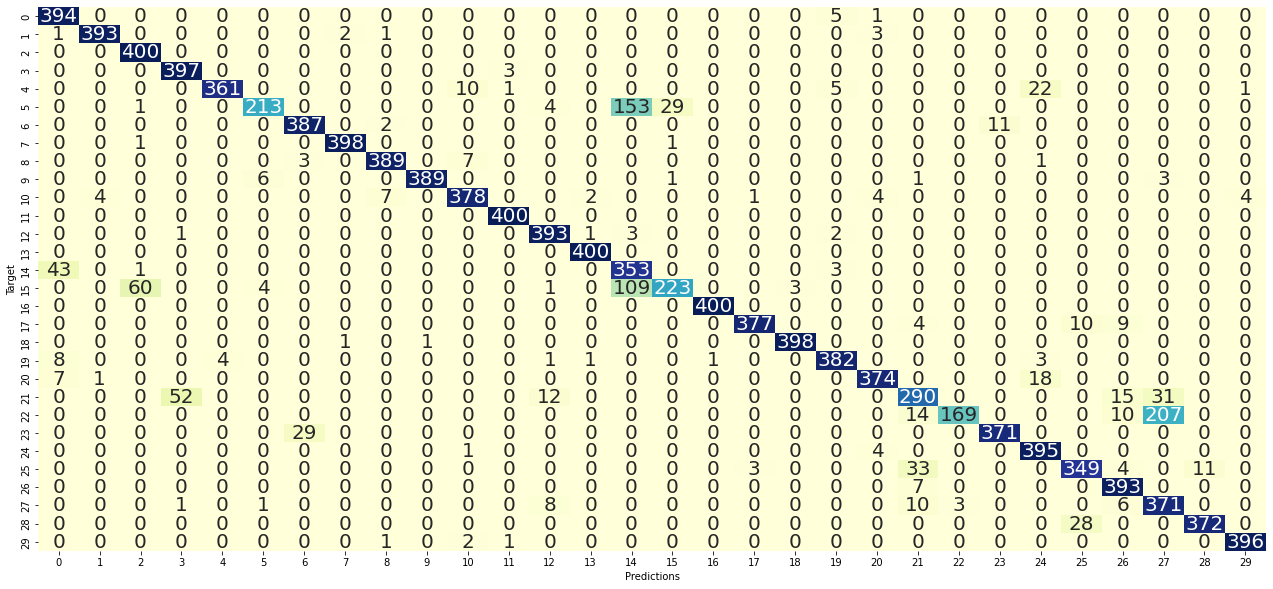

In [ ]:
predictions = modeloIQ.predict(x_test)

predicciones = []
for i in range(12000):
 predicciones.append(np.argmax(predictions[i]))

y_testeo = []
for i in range(12000):
 y_testeo.append(np.argmax(y_test[i]))

cm=confusion_matrix(y_testeo, predicciones)
cm_df=pd.DataFrame(cm)
plt.figure(figsize=(22,10))
sns.heatmap(cm_df, annot=True, cmap= "YlGnBu", annot_kws={"size": 20}, cbar=False, fmt='g');
plt.xlabel('Predictions');
plt.ylabel('Target');

print("Accuracy:")
aciertos = 0
for i in range(12000):
  if(y_testeo[i]==predicciones[i]):
    aciertos = aciertos+1

accuracy = aciertos/12000
print(accuracy)


##Se puede observar un incremento de aproximadamente 27% en la precisión de la detección del dispositivo que envía el paquete, con respecto a entrenar la red solo con paquetes que tienen LOS.
##Esto es razonable ya que al entrenar con paquetes que además de LOS, tengan Doppler y Multipath nos estamos ajustando a un entorno más realista.

<center><h1><b>BIBLIOGRAFÍA<h1></center>

- https://ieeexplore.ieee.org/abstract/document/9715147
- "Frequency Shift Chirp Modulation: The LoRa Modulation", author: Lorenzo Vangelista
- https://arxiv.org/pdf/2101.01668.pdf
